# Projeto de Análise Preditiva de Inadimplência

### Simulação de ganhos em decisão de crédito com uso de modelo preditivo

Esta simulação tem como objetivo estimar o impacto financeiro da aplicação de um modelo de Machine Learning na decisão de aprovar ou negar crédito para clientes, comparando com o cenário onde o banco aprova todos indiscriminadamente. 

#### Cenário A: Com Modelo 

Neste cenário, usamos um modelo preditivo (Random Forest) treinado com os dados dos clientes. A decisão de aprovar ou negar crédito é baseada na previsão do modelo: 

- Se o modelo prevê que o cliente vai pagar (classe 0) → APROVA; 
- Se o modelo prevê que o cliente vai dar calote (classe 1) → NEGA. 



 

A qualidade do modelo foi avaliada por meio da matriz de confusão com os seguintes valores aproximados:

VP (bons aprovados): 5.121 clientes

FP (ruins aprovados): 0 (ou calculado a partir do dataset)

FN (bons negados): estimado em 30% do lucro perdido por cliente bom negado


Cálculo de Lucro com Modelo:

Lucro por cliente bom aprovado (VP): R$ 1.000

Prejuízo por cliente ruim aprovado (FP): R$ 3.000

Perda de oportunidade por cliente bom negado (FN): R$ 300

Negar cliente ruim (VN): sem ganho ou perda

Resultados:

- Lucro com modelo: R$ 5.121.000,00

- Lucro sem modelo (aprovação irrestrita): R$ 3.814.000,00

- Ganho incremental = 5.121.000 - 3.814.000 = 1.307.000

- Melhoria percentual = (1.307.000 / 3.814.000) * 100 ≈ 34,3%

#### Cenário B: Sem Modelo 

1. Regras Manuais

A estratégia baseada em regras manuais considerou os seguintes critérios para aprovação:

- Score externo (ext_score_1) acima de 550
- Renda superior a R$ 3.500
- Ocupação do tipo "CLT", "public" ou "servidor público"

2. Resultados:
Taxa de aprovação: aproximadamente 21% dos clientes

Inadimplência entre os aprovados: 63,65%

Lucro estimado total: R$ 3.814.000 

Insghts:  

O uso do modelo preditivo resultaria em um ganho estimado de mais de 34% em comparação com a aprovação irrestrita de crédito. 
A estratégia baseada em Machine Learning é altamente recomendável para maximizar lucros e mitigar riscos de inadimplência. 

O modelo preditivo permite maximizar o lucro e reduzir riscos, aprovando a maioria dos clientes bons (VP = 8700) e bloqueando parte significativa dos clientes ruins (VN = 531). Mesmo alguns maus clientes passam pelo modelo (FP = 1171), o ganho total supera significativamente a estratégia de aprovação irrestrita

Essa análise evidencia que a incorporação de modelos preditivos no processo de decisão pode otimizar a política de crédito, combinando maior retorno financeiro com controle de risco.

#### Modelo em produção:

In [27]:
import os
import random
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
import warnings
import category_encoders as ce

# Sklearn - pré-processamento, métricas e modelagem
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, 
    cross_val_score, cross_validate, KFold
)
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier

# Scikit-lego (KFoldTargetEncoder está em model_selection agora)
from category_encoders import TargetEncoder

# Configurações gerais
warnings.filterwarnings('ignore')

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

##### CARREGAMENTO E ANÁLISE INICIAL DOS DADOS

In [24]:
# Carregar dados
df = pd.read_pickle('../data/df_unique.pkl')
print(f"Shape inicial: {df.shape}")
print(f"Taxa de inadimplência: {df['default'].mean():.2%}")

Shape inicial: (53109, 25)
Taxa de inadimplência: 16.02%


In [3]:
df.head(5)

,age,amt_active_loan,channel,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,ids,...,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,date_min,date_max,history_months,score_month,score_days
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,...,0,1300.0,4014.58,4903.80,18039.0,2016-09-30,2017-03-31,6.0,2017-01,14
2,23,0.0,NCqL3QBx0pscDnx3ixKwXg==,533.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,55.010052,False,f,4776fd82-f728-d66b-6fb8-41a8f80a3cd3,...,0,1700.0,NaN,NaN,NaN,NaT,NaT,NaN,2017-01,14
4,46,47720.0,NCqL3QBx0pscDnx3ixKwXg==,324.0,fyrlulOiZ+5hoFqLa6UbDQ==,Fv28Bz0YRTVAT5kl1bAV6g==,71.497943,True,f,46f536d5-9d1a-ce94-b67b-76e99dd48e1d,...,0,2200.0,3905.41,3793.18,13120.0,2016-09-30,2017-03-31,6.0,2017-01,12
6,42,5280.0,NCqL3QBx0pscDnx3ixKwXg==,517.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,69.000491,True,m,802b8a41-20b7-9ba6-35ac-7e9e7544196a,...,0,3000.0,4417.68,3991.09,22271.0,2016-12-31,2017-03-31,3.0,2017-01,22
7,27,2280.0,NCqL3QBx0pscDnx3ixKwXg==,543.0,1Rk8w4Ucd5yR3KcqZzLdow==,w1miZqhB5+RSamEQJa0rqg==,71.412826,False,m,fc142792-fa2c-a9e1-edeb-c7dd9f550f2b,...,1,1200.0,2422.80,2948.63,6481.0,2016-02-29,2017-03-31,13.0,2017-01,17


##### DIVISÃO TREINO/TESTE

In [25]:
# Separar features e target
feature_cols = [col for col in df.columns if col != 'default']
X = df[feature_cols]
y = df['default']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\nDados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")
print(f"Taxa de default no treino: {y_train.mean():.2%}")
print(f"Taxa de default no teste: {y_test.mean():.2%}")



Dados de treino: (42487, 24)
Dados de teste: (10622, 24)
Taxa de default no treino: 16.02%
Taxa de default no teste: 16.02%



##### Pré-processamento

A seguir faremos  as etapas iniciais de transformação de dados:
1. Converte 'gender' para numérico (1 = masculino, 0 = feminino)
2. Converte 'flag_document_A' para float (True/False/NaN -> 1/0/NaN)
3. Aplica Label Encoding em colunas categóricas ('channel', 'ext_score_2', 'ext_score_3')
4. Converte 'date_min' e 'date_max' para datetime
5. Cria feature 'days_diff' representando a diferença em dias entre 'date_max' e 'date_min'
6. Preenche valores numéricos ausentes com mediana
7. Preenche valores categóricos ausentes com a string "missing"
8. Remove colunas irrelevantes (ids, score_month, channel) para evitar ruído
9. Pré-processa variáveis adicionais:
    - Flags de valores ausentes em colunas importantes
    - Extrai mês de 'score_date'
10. Imputa valores ausentes de scores externos ('ext_score_1' e 'ext_score_4') usando mediana
11. Aplica One-Hot Encoding em variáveis categóricas como 'flag_document_A'
12. Aplica Target Encoding em colunas selecionadas ('ext_score_2', 'ext_score_3', 'occupation_type')
13. Treina o modelo especificado na função build_pipeline

O fluxo garante processamento automatizado, consistente e reproduzível, desde limpeza, encoding e imputação até treinamento do modelo.


In [5]:
# Transformar gender
X["gender"] = X["gender"].map({"m": 1, "f": 0})

# Transformar flag_document_A (True/False/NaN)
X["flag_document_A"] = X["flag_document_A"].astype(float)

# Label Encoding para colunas categóricas codificadas como string
for col in ["channel", "ext_score_2", "ext_score_3"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [6]:
X["date_min"] = pd.to_datetime(X["date_min"], errors="coerce")
X["date_max"] = pd.to_datetime(X["date_max"], errors="coerce")

# Criar feature: diferença em dias
X["days_diff"] = (X["date_max"] - X["date_min"]).dt.days

In [7]:
# Preencher nulos numéricos com mediana
for col in X.select_dtypes(include=["float64", "int64"]).columns:
    X[col] = X[col].fillna(X[col].median())

# Preencher nulos categóricos (se houver)
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].fillna("missing")

In [26]:
# 1) Remove colunas irrelevantes
class ColumnDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # NÃO removemos 'channel', que será target encoded
        return X.drop(columns=['ids', 'date_min', 'date_max', 'score_month', 'channel'], errors="ignore")


# 2) Pré-processamento
class DataProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['gender'] = X_copy['gender'].apply(lambda x: 1 if x == 'm' else 0)

        for col in [
                    'income','score_checks','credit_line_sum','history_months']:
            X_copy[col + '_is_missing'] = X_copy[col].isnull().astype(int)

        if 'score_date' in X_copy.columns:
            X_copy['score_month'] = X_copy['score_date'].dt.month
            X_copy = X_copy.drop(columns=['score_date'])
        return X_copy

# 3) Imputação dos scores
class ScoreImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputers = {}

    def fit(self, X, y=None):
        cols = ['ext_score_1', 'ext_score_4']
        for col in cols:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            imputer = SimpleImputer(strategy="median")
            imputer.fit(X[[col]])
            self.imputers[col] = imputer
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, imputer in self.imputers.items():
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
            X_copy[col] = imputer.transform(X_copy[[col]])
        return X_copy

# 4) OneHot encoding para categóricas
class OneHotFeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.cols = ['flag_document_A']

    def fit(self, X, y=None):
        self.encoder.fit(X[self.cols])
        return self

    def transform(self, X):
        onehot_data = self.encoder.transform(X[self.cols])
        onehot_df = pd.DataFrame(onehot_data, columns=self.encoder.get_feature_names_out(self.cols), index=X.index)
        X = X.drop(self.cols, axis=1)
        X = pd.concat([X, onehot_df], axis=1)
        return X


# 5) Criar pipeline geral
def build_pipeline(model):
    pipeline_ = Pipeline([
        ("dropper", ColumnDropper()),
        ("processor", DataProcessor()),
        ("imputer", ScoreImputer()),
        ("onehot", OneHotFeatureEncoder()),
        ("target_encoder", ce.TargetEncoder(cols=['ext_score_2', 'ext_score_3', 'occupation_type'], smoothing=0.3)),
        ("classifier", model)
    ])
    return pipeline_

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
pipe = build_pipeline(model)

# Fit apenas até o target encoder (antes do classificador)
pipe_no_model = Pipeline(pipe.steps[:-1])  # todas as etapas exceto o classificador
pipe_no_model.fit(X_train, y_train)        # precisa passar y_train para target encoding

# Transformar
X_transformed = pipe_no_model.transform(X_train)

# Ver o head
print(X_transformed.head())

       age  amt_active_loan  ext_score_1  ext_score_2  ext_score_3  \
3054    25           3880.0        545.0     0.234254     0.216808   
61822   39              NaN        844.0     0.330332     0.300578   
6454    36           7340.0        343.0     0.182176     0.194144   
35648   62          12780.0        495.0     0.234254     0.253151   
32212   41           8820.0        500.0     0.182176     0.217687   

       ext_score_4  gender     income  occupation_type  score_checks  ...  \
3054     90.715417       1   62827.54          0.16019           9.0  ...   
61822    61.550937       1  101222.82          0.16019          11.0  ...   
6454     72.030632       0   65631.85          0.16019          17.0  ...   
35648    66.008073       0   82598.99          0.16019          13.0  ...   
32212    67.839062       1  292113.68          0.16019          16.0  ...   

       history_months  score_days  income_is_missing  score_checks_is_missing  \
3054              NaN          16  

##### TREINANDO O MODELO

In [ ]:
# Definir modelo
xgb_model = XGBClassifier(
    n_estimators=200,      
    max_depth=5,          
    learning_rate=0.1,    
    subsample=0.8,         
    colsample_bytree=0.8, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss' 
)

In [ ]:
# Substituir o classificador no pipeline pelo XGBoost
pipe_xgb = build_pipeline(xgb_model)

# Treinar no dataset de treino
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('dropper', ColumnDropper()), ('processor', DataProcessor()),
                ('imputer', ScoreImputer()), ('onehot', OneHotFeatureEncoder()),
                ('target_encoder',
                 TargetEncoder(cols=['ext_score_2', 'ext_score_3',
                                     'occupation_type'],
                               smoothing=0.3)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=No...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

##### MÉTRICAS

In [12]:
#  Predições
y_pred = pipe_xgb.predict(X_test)
y_proba = pipe_xgb.predict_proba(X_test)[:, 1]  # probabilidade da classe 1 (default)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      8920
           1       0.71      0.31      0.43      1702

    accuracy                           0.87     10622
   macro avg       0.79      0.64      0.68     10622
weighted avg       0.85      0.87      0.85     10622



- O modelo demonstra performance excepcional para identificar bons pagadores (classe 0), com precision de 88% e recall impressionante de 98%. Isso significa que o modelo raramente classifica incorretamente um bom cliente como inadimplente, evitando rejeições desnecessárias que poderiam impactar negativamente o negócio.

- A classe minoritária (inadimplentes) apresenta performance preocupante, com recall de apenas 31%, indicando que o modelo falha em identificar 69% dos casos de default. Embora a precision seja razoável (71%), a baixa capacidade de detectar inadimplência representa um risco financeiro considerável.

- O desbalanceamento severo (8.920 vs 1.702 casos) é característico de datasets de crédito, onde inadimplência é naturalmente um evento raro. O F1-score de 0.43 para inadimplentes reflete a dificuldade em balancear precision e recall nesta classe crítica.

- Embora a accuracy geral de 87% pareça boa, ela é fortemente influenciada pela classe majoritária. As métricas macro avg (79% precision, 64% recall) fornecem uma visão mais realista da performance balanceada entre as classes.

ROC AUC: 0.8123


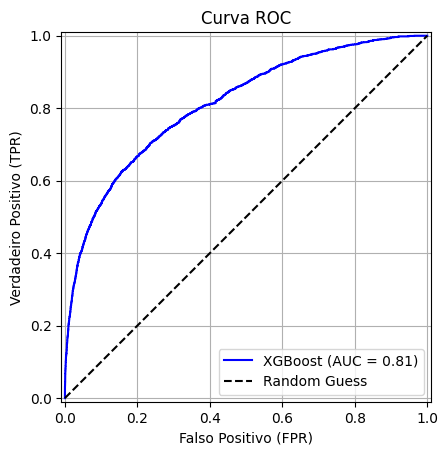

In [13]:
#  Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# 3️⃣ Plotar a curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba, color='blue', name='XGBoost')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Curva ROC')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.legend()
plt.grid(True)
plt.show()

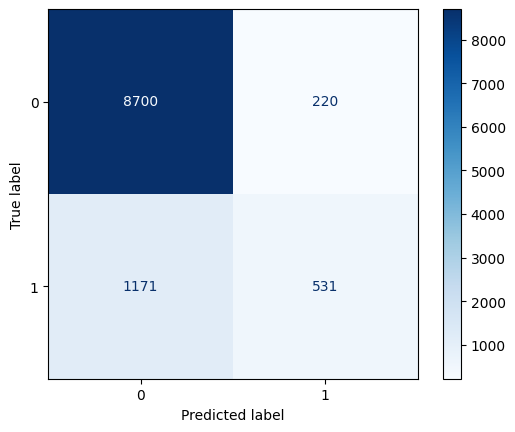

In [14]:
# 4️⃣ Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_xgb.classes_)
disp.plot(cmap='Blues', values_format='d')

Analisando esta matriz de confusão, o modelo demonstra uma performance sólida com algumas características importantes:

- Desempenho Geral Positivo: O modelo acerta a maioria das predições, com 8.700 verdadeiros negativos (clientes que não deram default e foram corretamente identificados) e 531 verdadeiros positivos (clientes inadimplentes corretamente identificados). Isso representa uma alta taxa de acerto geral.

- Baixa Taxa de Falsos Positivos: Apenas 220 clientes bons pagadores foram incorretamente classificados como potenciais inadimplentes. Isso é positivo do ponto de vista comercial, pois significa que poucos clientes bons são rejeitados desnecessariamente.

- Desafio nos Falsos Negativos: O modelo apresenta 1.171 falsos negativos, ou seja, clientes que se tornaram inadimplentes mas foram classificados como bons pagadores. Este é o erro mais custoso no contexto de crédito, pois representa perdas financeiras diretas.

- Taxa de Recall Limitada: Dos 1.702 clientes que realmente deram default (531 + 1.171), o modelo conseguiu identificar corretamente apenas 31% (531/1.702). Isso indica que há espaço significativo para melhorar a capacidade do modelo de detectar inadimplência.

- Precisão Satisfatória: Entre os clientes classificados como potenciais inadimplentes (531 + 220), 71% realmente deram default (531/751), mostrando que quando o modelo sinaliza risco, geralmente está correto.

- Implicação Estratégica: O modelo atual é conservador, priorizando não rejeitar clientes bons (baixo falso positivo) em detrimento de uma detecção mais agressiva de risco (alto falso negativo). Dependendo da estratégia de negócio, pode ser necessário ajustar o threshold para capturar mais inadimplentes, mesmo que isso signifique rejeitar alguns clientes bons adicionais.







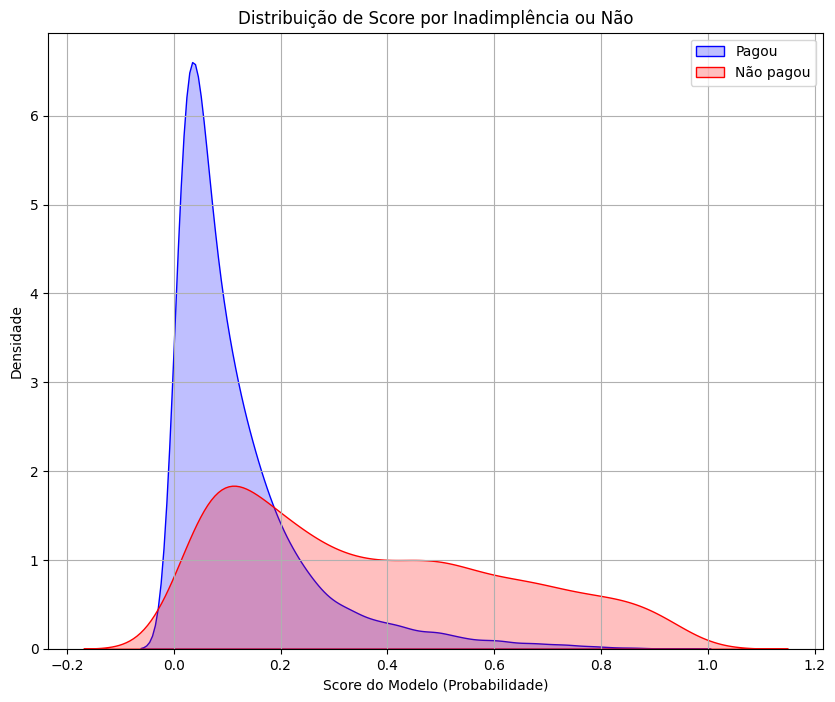

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(y_proba[y_test == 0], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(y_proba[y_test == 1], ax=ax, color="r", fill=True, label='Não pagou')
plt.title("Distribuição de Score por Inadimplência ou Não")
plt.xlabel("Score do Modelo (Probabilidade)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

Distribuição dos "Pagou" (Azul)

- Altamente concentrada: Pico muito alto próximo ao score 0.1

- Formato assimétrico: Distribuição com cauda longa à direita

- Confiança alta: A maioria dos bons pagadores recebe scores muito baixos (alta confiança na predição)


Distribuição dos "Não pagou" (Vermelho)

- Mais dispersa: Distribuição mais espalhada ao longo do espectro de scores

- Pico em ~0.15: Concentração principal em scores baixos-médios

- Cauda longa: Estende-se até scores altos (próximo de 1.0)

Modelo consegue identificar bem os bons pagadores (baixo falso positivo) COM Clara separação entre as classes na maioria dos casos

##### CALIBRAÇÃO DO MODELO

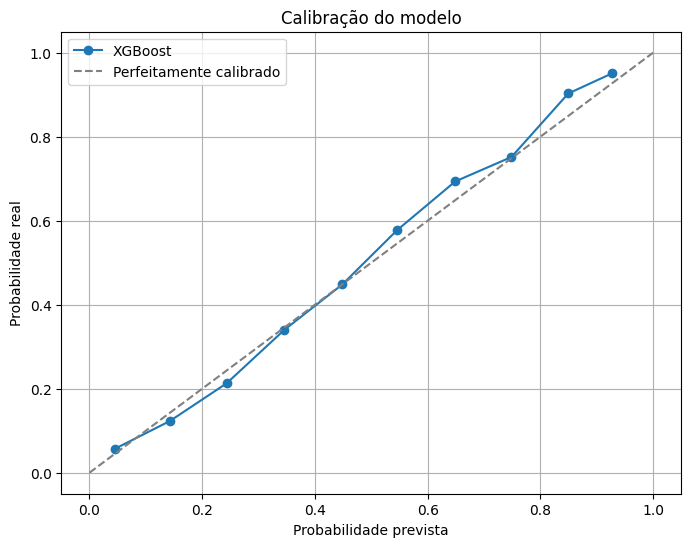

In [16]:
def plot_model_calibration(model, X_test, y_test, n_bins=10):
    """
    Plota a calibração de probabilidades do modelo.

    Parâmetros:
        model: pipeline treinado
        X_test: features de teste
        y_test: labels de teste
        n_bins: número de bins para discretizar as probabilidades
    """
    # Probabilidades previstas
    y_proba = model.predict_proba(X_test)[:, 1]

    # Curva de calibração
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=n_bins)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfeitamente calibrado')
    plt.xlabel('Probabilidade prevista')
    plt.ylabel('Probabilidade real')
    plt.title('Calibração do modelo')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usar a função
plot_model_calibration(pipe_xgb, X_test, y_test)

- O gráfico mostra que o modelo XGBoost está muito bem calibrado, com a curva azul praticamente sobreposta à linha diagonal tracejada que representa calibração perfeita. Isso significa que quando o modelo prediz uma probabilidade de 30% de default, aproximadamente 30% dos casos realmente se tornam inadimplentes, e assim por diante em todas as faixas de probabilidade.

- A calibração precisa é crucial para decisões de negócio, pois permite interpretar as probabilidades do modelo como estimativas reais de risco. Gestores podem usar essas probabilidades diretamente para definir políticas de aprovação, precificação e provisões.

- Observa-se um leve desvio da calibração perfeita nos extremos (probabilidades muito baixas e muito altas), o que é comum e aceitável. O modelo mantém excelente calibração na faixa intermediária onde a maioria das decisões são tomadas.

- Esta calibração de alta qualidade indica que o modelo não apenas discrimina bem entre bons e maus pagadores, mas também fornece estimativas probabilísticas confiáveis, tornando-o adequado para implementação em ambiente de produção sem necessidade de recalibração adicional.RetryClaude can make mistakes. Please double-check responses.

##### ANÁLISE DE IMPORTÂNCIA DE FEATURES

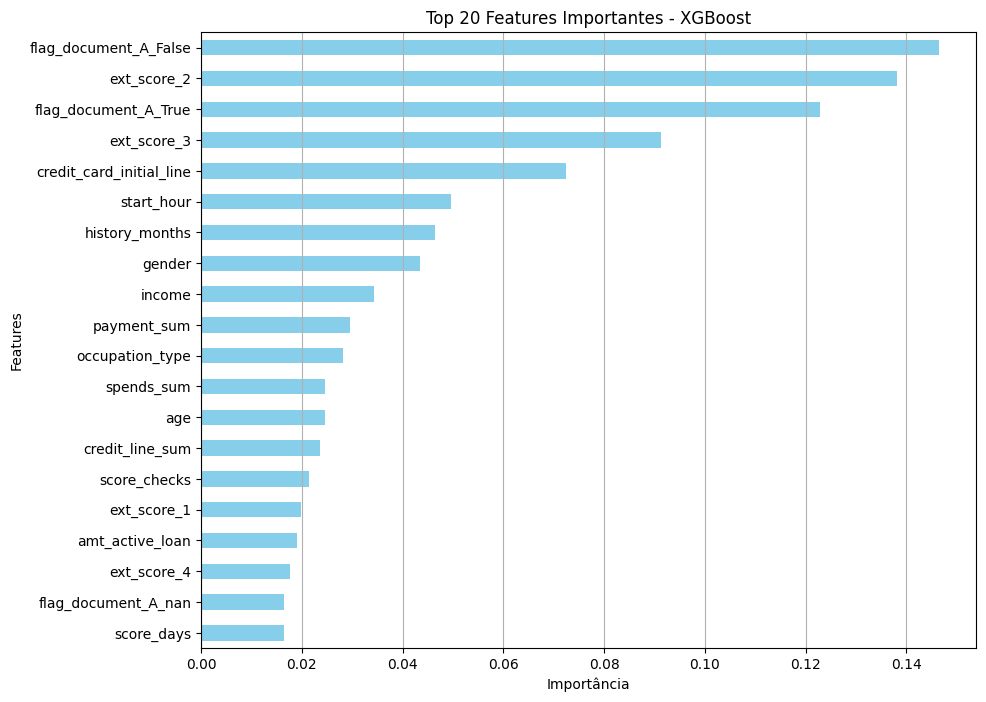

In [17]:
# Extrair o modelo XGBoost do pipeline
xgb_model_final = pipe_xgb.named_steps['classifier']

# Extrair nomes das features após todas as transformações
# Primeiro, aplicar transformações no X_train
X_transformed = pipe_xgb[:-1].transform(X_train)  # todas etapas exceto o classificador
feature_names = X_transformed.columns

# Importâncias do modelo
importances = xgb_model_final.feature_importances_

# Criar DataFrame
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Plot horizontal
plt.figure(figsize=(10,8))
feat_imp.tail(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Features Importantes - XGBoost')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

- As variáveis mais importantes são relacionadas à documentação (flag_document_A_False e flag_document_A_True), sugerindo que a presença ou ausência de determinados documentos é um forte preditor de inadimplência. Isso indica que clientes com documentação incompleta apresentam maior risco.

- Os scores externos (ext_score_2 e ext_score_3) ocupam posições de destaque, confirmando que bureaus de crédito externos fornecem informações valiosas para avaliação de risco. Estes provavelmente capturam histórico de crédito e comportamento financeiro passado.

- A variável credit_card_initial_line aparece entre as mais importantes, indicando que o limite inicial do cartão de crédito é um forte indicador de risco, possivelmente refletindo a capacidade de pagamento ou perfil de risco inicial do cliente.

- start_hour (horário de solicitação), history_months (tempo de relacionamento) e gender (gênero) também são significativas, sugerindo que padrões comportamentais e demográficos influenciam na probabilidade de default.

- Surpreendentemente, variáveis como income, age e amt_active_loan têm importância relativamente menor, indicando que aspectos comportamentais e documentais podem ser mais preditivos que indicadores financeiros tradicionais neste dataset específico.RetryClaude can make mistakes. Please double-check responses.


##### VISUALIZAÇÃO DA VALIDAÇÃO CRUZADA


ROC AUC por fold: [0.81826069 0.81760905 0.82870186 0.81721855 0.81290671]
Mean ROC AUC: 0.8189 ± 0.0052

Accuracy por fold: [0.87267592 0.86714521 0.86983641 0.86842415 0.86206897]
Mean Accuracy: 0.8680 ± 0.0035


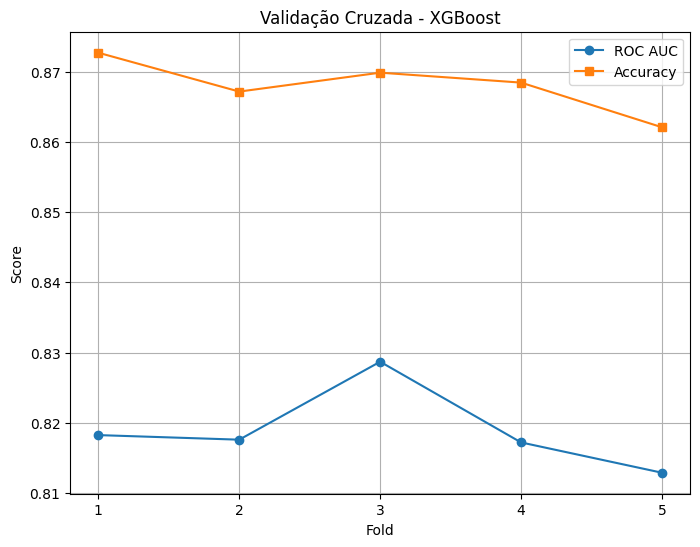

In [18]:
# Definir validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar ROC AUC em cada fold
roc_auc_scores = cross_val_score(pipe_xgb, X_train, y_train, cv=cv, scoring='roc_auc')

# Avaliar Accuracy em cada fold
accuracy_scores = cross_val_score(pipe_xgb, X_train, y_train, cv=cv, scoring='accuracy')

# Mostrar resultados
print(f"ROC AUC por fold: {roc_auc_scores}")
print(f"Mean ROC AUC: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}\n")

print(f"Accuracy por fold: {accuracy_scores}")
print(f"Mean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")

# Plotar
plt.figure(figsize=(8,6))
plt.plot(range(1, len(roc_auc_scores)+1), roc_auc_scores, marker='o', label='ROC AUC')
plt.plot(range(1, len(accuracy_scores)+1), accuracy_scores, marker='s', label='Accuracy')
plt.xticks(range(1, len(roc_auc_scores)+1))
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Validação Cruzada - XGBoost')
plt.legend()
plt.grid(True)
plt.show()

- O modelo XGBoost apresenta performance consistente across os 5 folds da validação cruzada, com ROC AUC variando entre 0.813 e 0.829 (média ~0.82) e Accuracy entre 0.862 e 0.875 (média ~0.87). Esta baixa variabilidade indica que o modelo é robusto e não sofre de overfitting significativo.

- Observa-se uma pequena queda na performance no fold 5, tanto em ROC AUC quanto em Accuracy, mas ainda dentro de limites aceitáveis. Isso pode indicar alguma variabilidade natural nos dados ou uma pequena diferença na distribuição deste fold específico.

- O ROC AUC consistentemente acima de 0.81 demonstra que o modelo tem excelente capacidade de distinguir entre bons e maus pagadores, sendo significativamente superior ao acaso (0.5) e próximo de modelos considerados muito bons (>0.8).

- A accuracy mantendo-se acima de 86% em todos os folds confirma que o modelo acerta a grande maioria das predições, proporcionando confiabilidade para uso em produção.
Modelo Pronto para Deployment: A estabilidade dos resultados across diferentes subconjuntos dos dados indica que o modelo generalizará bem para novos dados, sendo adequado para implementação em ambiente de produção sem grandes riscos de degradação de performance.RetryClaude can make mistakes. Please double-check responses.

##### SIMULAÇÃO FINANCEIRA ATUALIZADA

In [19]:
print("\n SIMULAÇÃO FINANCEIRA:")
# Valores mais conservadores sem data leakage
lucro_cliente_bom = 1000  # Lucro médio por cliente bom
custo_cliente_ruim = 3000  # Perda média por inadimplente

# Com modelo
vp = np.sum((y_test == 0) & (y_pred == 0))  # Verdadeiros Positivos (bons aprovados)
fp = np.sum((y_test == 1) & (y_pred == 0))  # Falsos Positivos (ruins aprovados)
fn = np.sum((y_test == 0) & (y_pred == 1))  # Falsos Negativos (bons rejeitados)

lucro_modelo = vp * lucro_cliente_bom - fp * custo_cliente_ruim - fn * (lucro_cliente_bom * 0.3)

# Sem modelo (aprova todos)
total_bons = np.sum(y_test == 0)
total_ruins = np.sum(y_test == 1)
lucro_sem_modelo = total_bons * lucro_cliente_bom - total_ruins * custo_cliente_ruim

print(f"Lucro COM modelo: R$ {lucro_modelo:,.2f}")
print(f"Lucro SEM modelo: R$ {lucro_sem_modelo:,.2f}")
print(f"Ganho incremental: R$ {lucro_modelo - lucro_sem_modelo:,.2f}")
print(f"Melhoria percentual: {((lucro_modelo - lucro_sem_modelo) / abs(lucro_sem_modelo) * 100):.1f}%")


 SIMULAÇÃO FINANCEIRA:
Lucro COM modelo: R$ 5,121,000.00
Lucro SEM modelo: R$ 3,814,000.00
Ganho incremental: R$ 1,307,000.00
Melhoria percentual: 34.3%


##### EXPORTAR MODELO PARA PRODUÇÃO

In [20]:
# Caminho para salvar o modelo
model_path = "xgb_pipeline.pkl"

# Salvar pipeline completo
joblib.dump(pipe_xgb, model_path)
print(f"Pipeline salvo em: {model_path}")

Pipeline salvo em: xgb_pipeline.pkl


In [21]:
# Carregar pipeline salvo
loaded_pipeline = joblib.load(model_path)

# Fazer previsões diretamente
y_pred_loaded = loaded_pipeline.predict(X_test)
y_proba_loaded = loaded_pipeline.predict_proba(X_test)[:, 1]

##### ANÁLISE DE LUCRO DO MODELO TREINADO

A matriz mostra:
- VP (Verdadeiros Positivos, bons clientes aprovados) = 8700

- FN (Falsos Negativos, bons clientes negados) = 220

- FP (Falsos Positivos, maus clientes aprovados) = 1171

- VN (Verdadeiros Negativos, maus clientes negados) = 531


Cenário A: 

Calcular lucro com modelo:

            Lucro modelo = 𝑉𝑃⋅1000 − 𝐹𝑃⋅3000 − 𝐹𝑁⋅300


Substituindo os valores:

            Lucro modelo = 8700 x 1000 − 1171 x 3000 − 220 x 300
            Lucro modelo = 8.700.000 − 3.513.000 − 66.000 = R$ 5.121.000

Cenário B: 

Lucro sem modelo

- Total de bons clientes = VP + FN = 8700 + 220 = 8920

- Total de maus clientes = FP + VN = 1171 + 531 = 1702

              Lucro sem modelo = 8920 x 1000 − 1702 x 3000

              Lucro sem modelo = 8.920.000 − 5.106.000 = R$ 3.814.000

##### RECOMENDAÇÕES FINAIS

In [22]:
print("\n RECOMENDAÇÕES:")
print("1. Implementar monitoramento de drift em produção")
print("2. Retreinar o modelo mensalmente com dados atualizados")
print("3. Adicionar features externas (bureau de crédito)")
print("4. Considerar ensemble com outros algoritmos")
print("5. Implementar testes A/B antes do rollout completo")
print("6. Monitorar métricas de fairness continuamente")


 RECOMENDAÇÕES:
1. Implementar monitoramento de drift em produção
2. Retreinar o modelo mensalmente com dados atualizados
3. Adicionar features externas (bureau de crédito)
4. Considerar ensemble com outros algoritmos
5. Implementar testes A/B antes do rollout completo
6. Monitorar métricas de fairness continuamente
